# Variant effect and variance explained analysis

This notebook aims to create visualisations of the `variant effect` and `variance explained` dataset generated by previous notebooks in this chapter.

In [ ]:
import matplotlib.pyplot as plt
import polars as pl
import seaborn as sns

sns.set_style("white")
sns.set_context("paper", font_scale=1.0)
sns.set_palette(sns.color_palette("rocket"))


In [ ]:
df = pl.read_parquet("lead-maf-vep-ve.parquet")


In [7]:
def plot_maf_vs_cs_size(data: pl.DataFrame, ax):
    assert "majorPopulationMAF" in data.columns
    assert "credibleSetSize" in data.columns
    data = data.select(pl.col("majorPopulationMAF"), pl.col("credibleSetSize"))
    return sns.scatterplot(
        data=data,
        x="majorPopulationMAF",
        y="credibleSetSize",
        ax=ax,
        alpha=0.05,
        # line_kws=dict(color="r"),
    )


def plot_maf_vs_cs_size_weighted(data: pl.DataFrame, ax):
    assert "majorPopulationMAF" in data.columns
    assert "credibleSetSize" in data.columns
    data = (
        data.select(pl.col("majorPopulationMAF"), pl.col("credibleSetSize"))
        .group_by("majorPopulationMAF", "credibleSetSize")
        .len()
        .select("majorPopulationMAF", "credibleSetSize", pl.col("len").alias("weight"))
    )
    return sns.relplot(
        data=data,
        x="majorPopulationMAF",
        y="credibleSetSize",
        size="weight",
        # alpha=0.05,
        sizes=(1, 100),
        ax=ax,
        # line_kws=dict(color="r"),
    )


def plot_af_vs_cs_size(data: pl.DataFrame, ax):
    assert "credibleSetSize" in data.columns
    assert "majorPopulationAlleleFrequency" in data.columns
    data = data.select(
        pl.col("majorPopulationAlleleFrequency")
        .list.first()
        .struct.field("alleleFrequency")
        .alias("majorPopulationAF"),
        pl.col("credibleSetSize"),
    )
    # print(data.schema)
    return sns.scatterplot(
        data=data,
        x="majorPopulationAF",
        y="credibleSetSize",
        ax=ax,
        alpha=0.05,
        # line_kws=dict(color="r"),
    )


def plot_n_vs_cs_size(data: pl.DataFrame, ax):
    assert "nSamples" in data.columns
    assert "credibleSetSize" in data.columns
    data = data.select(pl.col("nSamples"), pl.col("credibleSetSize"))
    return sns.scatterplot(
        data=data,
        x="nSamples",
        y="credibleSetSize",
        ax=ax,
        alpha=0.05,
        # line_kws=dict(color="r"),
    )


def plot_var_vs_cs_size(data: pl.DataFrame, ax):
    assert "varianceExplained" in data.columns
    assert "credibleSetSize" in data.columns
    data = data.select(pl.col("varianceExplained"), pl.col("credibleSetSize"))
    return sns.scatterplot(
        data=data,
        x="varianceExplained",
        y="credibleSetSize",
        ax=ax,
        # alpha=0.05,
        # line_kws=dict(color="r"),
    )


def plot_var_vs_MAF(data: pl.DataFrame, ax):
    assert "varianceExplained" in data.columns
    assert "majorPopulationMAF" in data.columns
    data = data.select(pl.col("varianceExplained"), pl.col("majorPopulationMAF"))
    return sns.scatterplot(
        data=data,
        y="varianceExplained",
        x="majorPopulationMAF",
        ax=ax,
        # alpha=0.05,
        # line_kws=dict(color="r"),
    )


### MAF vs credible set size

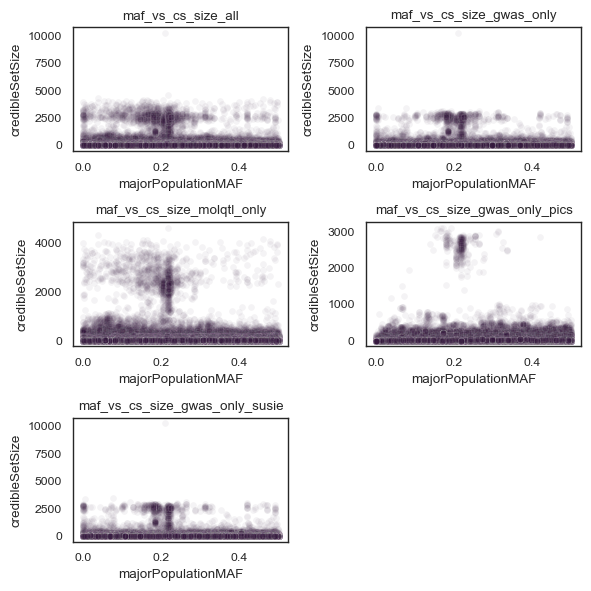

In [ ]:
data = df
data2 = df.filter(pl.col("studyType") == "gwas")
data3 = df.filter(pl.col("studyType") != "gwas")
data4 = df.filter(pl.col("studyType") == "gwas").filter(pl.col("finemappingMethod") == "PICS")
data5 = df.filter(pl.col("studyType") == "gwas").filter(pl.col("finemappingMethod") != "PICS")

fig = plt.figure(figsize=(6, 6))
ax1 = plt.subplot(3, 2, 1)
ax2 = plt.subplot(3, 2, 2)
ax3 = plt.subplot(3, 2, 3)
ax4 = plt.subplot(3, 2, 4)
ax5 = plt.subplot(3, 2, 5)
plot_maf_vs_cs_size(data, ax1).set_title("maf_vs_cs_size_all")
plot_maf_vs_cs_size(data2, ax2).set_title("maf_vs_cs_size_gwas_only")
plot_maf_vs_cs_size(data3, ax3).set_title("maf_vs_cs_size_molqtl_only")
plot_maf_vs_cs_size(data4, ax4).set_title("maf_vs_cs_size_gwas_only_pics")
plot_maf_vs_cs_size(data5, ax5).set_title("maf_vs_cs_size_gwas_only_susie")
fig.tight_layout()

plt.show()


### MAF vs credible set size per studyType

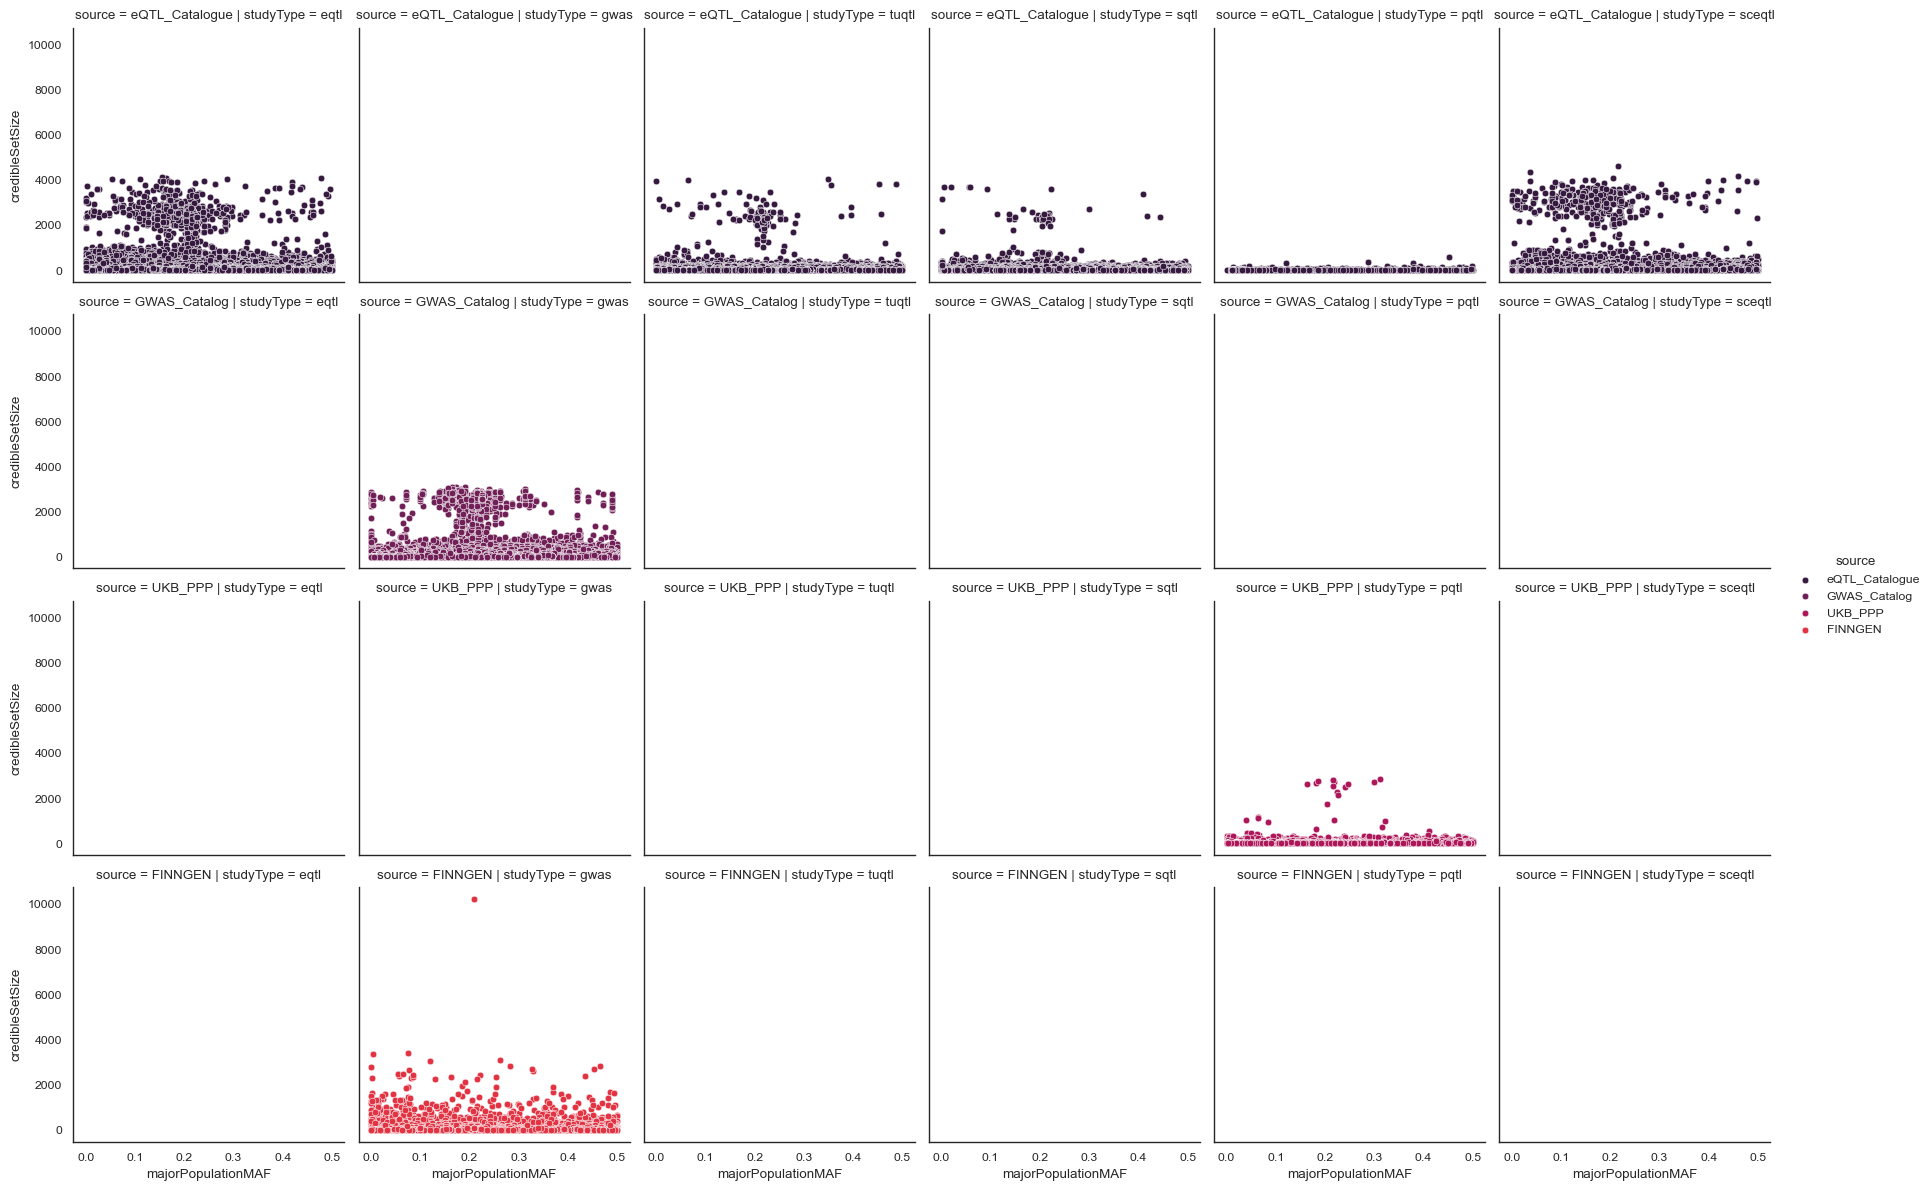

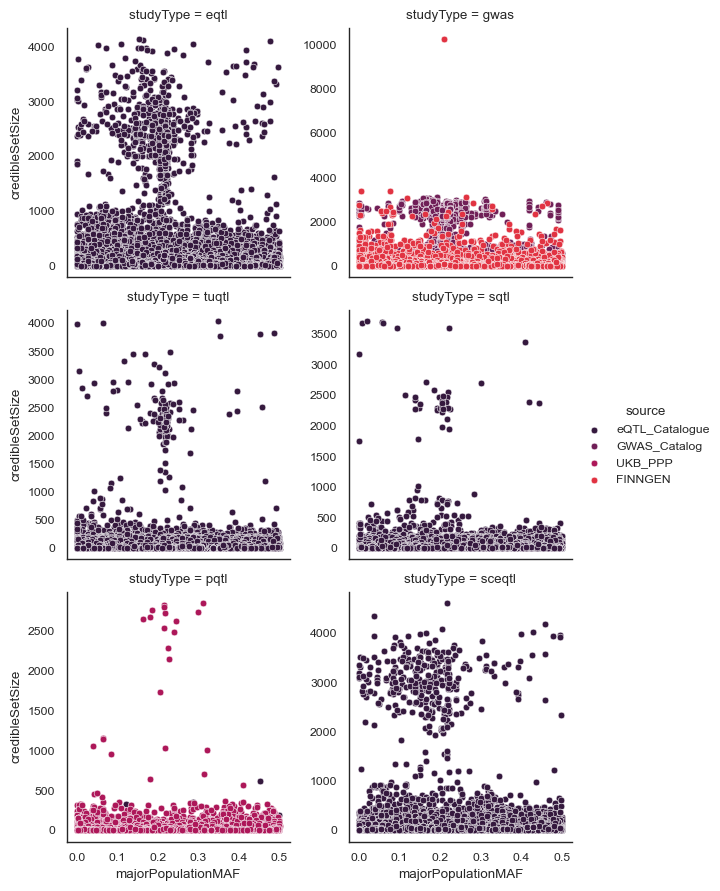

In [17]:
data = df.select(
    "majorPopulationMAF",
    "credibleSetSize",
    "studyType",
    "studyId",
    pl.when(pl.col("studyId").str.starts_with("GCST"))
    .then(pl.lit("GWAS_Catalog"))
    .when(pl.col("studyId").str.starts_with("FINNGEN"))
    .then(pl.lit("FINNGEN"))
    .when(pl.col("studyId").str.starts_with("UKB"))
    .then(pl.lit("UKB_PPP"))
    .otherwise(pl.lit("eQTL_Catalogue"))
    .alias("source"),
)
g = sns.FacetGrid(data, col="studyType", row="source", hue="source")
g.map(sns.scatterplot, "majorPopulationMAF", "credibleSetSize")
g.add_legend()

g2 = sns.FacetGrid(data, col="studyType", hue="source", col_wrap=2, sharey=False)
g2.map(
    sns.scatterplot,
    "majorPopulationMAF",
    "credibleSetSize",
)
g2.add_legend()

plt.show()


### sample size vs credible set size

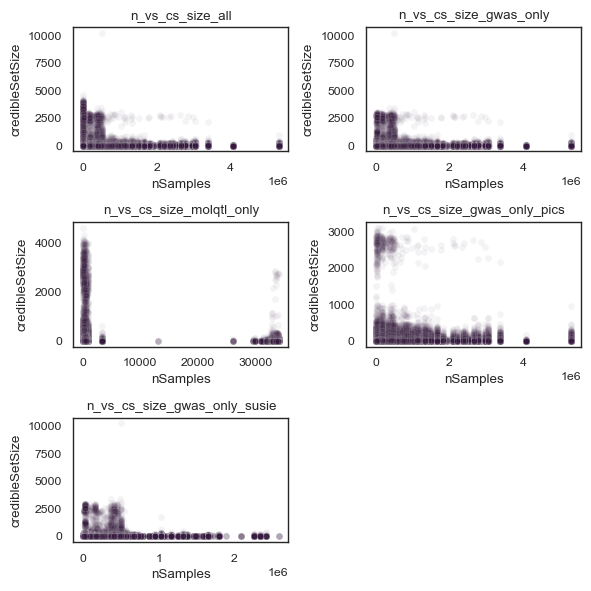

In [9]:
data = df
data2 = df.filter(pl.col("studyType") == "gwas")
data3 = df.filter(pl.col("studyType") != "gwas")
data4 = df.filter(pl.col("studyType") == "gwas").filter(pl.col("finemappingMethod") == "PICS")
data5 = df.filter(pl.col("studyType") == "gwas").filter(pl.col("finemappingMethod") != "PICS")

fig = plt.figure(figsize=(6, 6))
ax1 = plt.subplot(3, 2, 1)
ax2 = plt.subplot(3, 2, 2)
ax3 = plt.subplot(3, 2, 3)
ax4 = plt.subplot(3, 2, 4)
ax5 = plt.subplot(3, 2, 5)
plot_n_vs_cs_size(data, ax1).set_title("n_vs_cs_size_all")
plot_n_vs_cs_size(data2, ax2).set_title("n_vs_cs_size_gwas_only")
plot_n_vs_cs_size(data3, ax3).set_title("n_vs_cs_size_molqtl_only")
plot_n_vs_cs_size(data4, ax4).set_title("n_vs_cs_size_gwas_only_pics")
plot_n_vs_cs_size(data5, ax5).set_title("n_vs_cs_size_gwas_only_susie")
fig.tight_layout()

plt.show()


### sample size vs credible set size per studyType

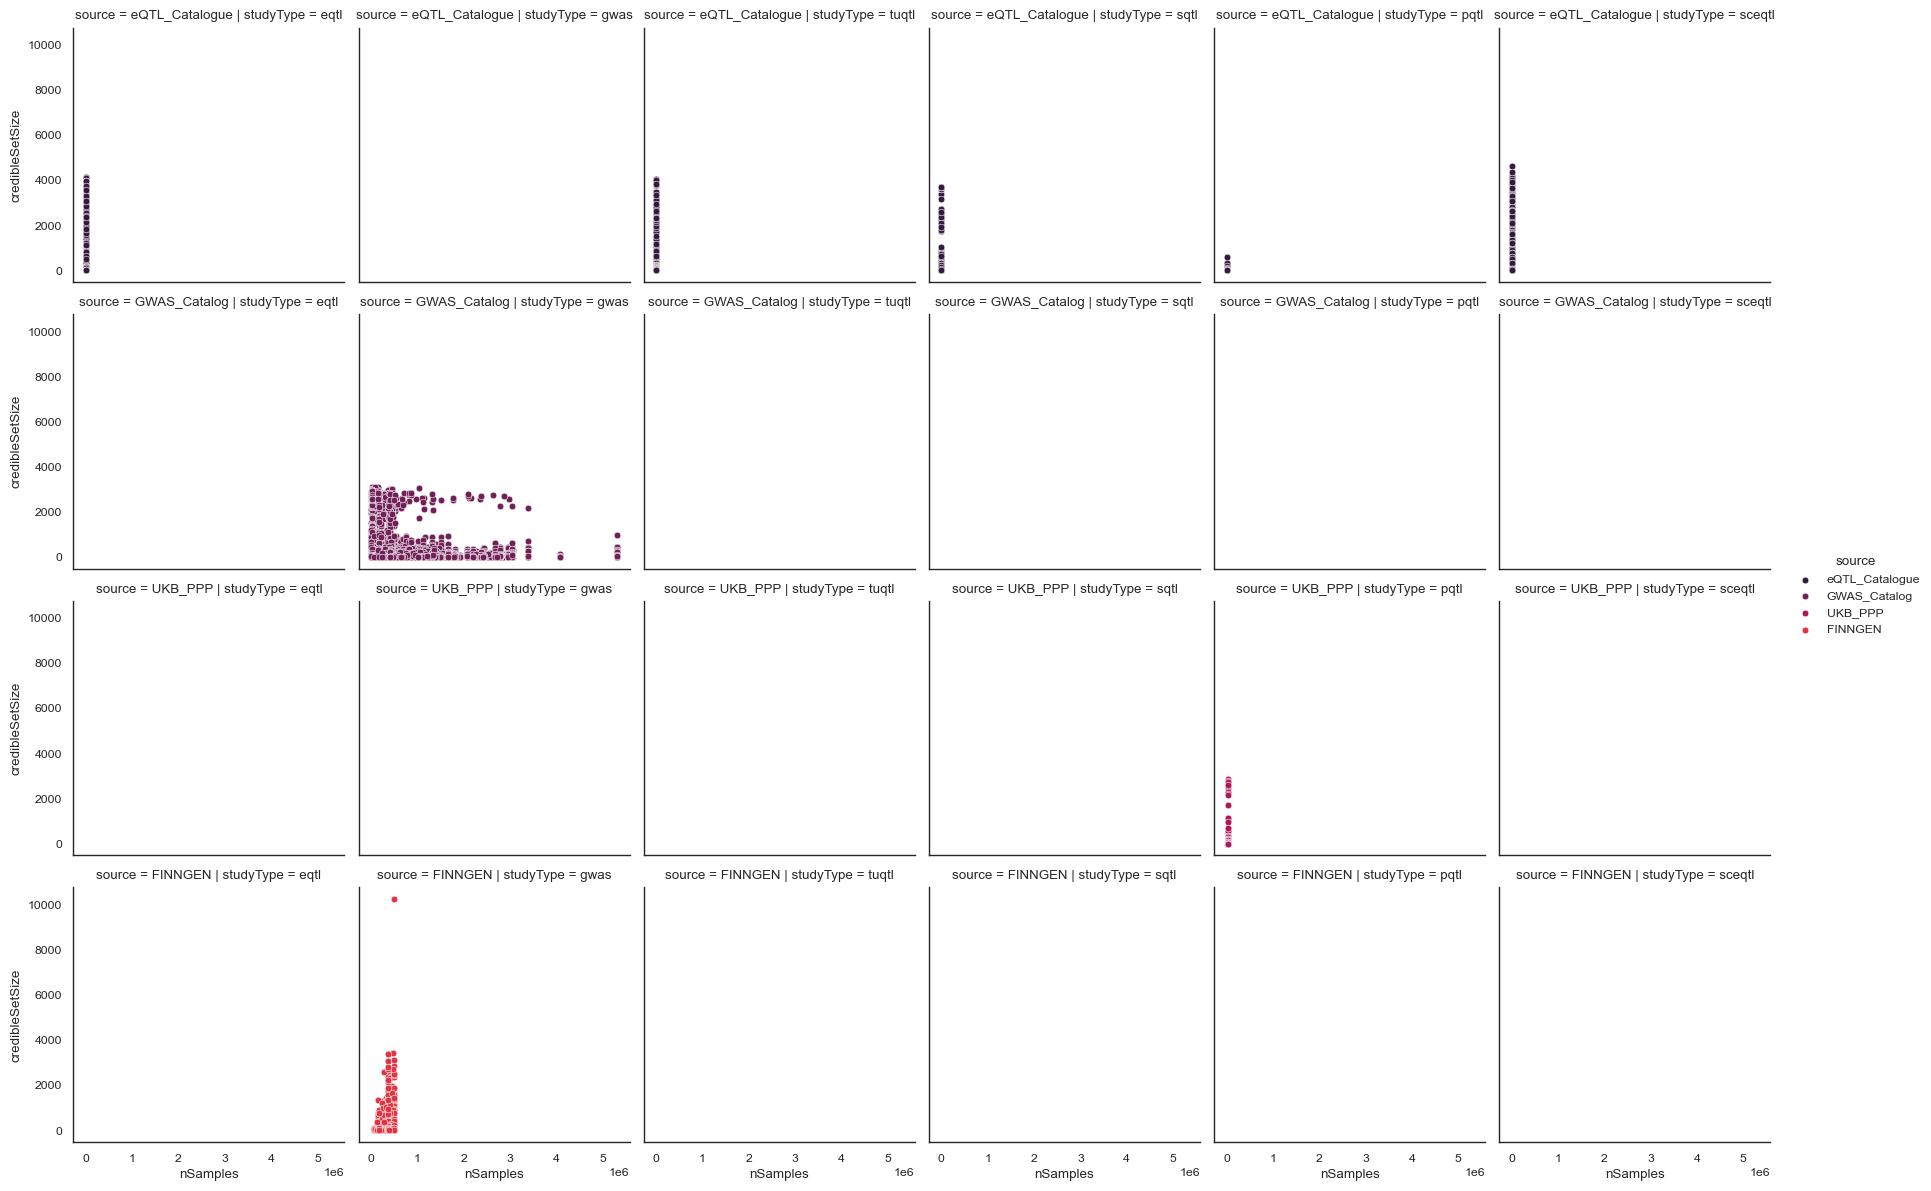

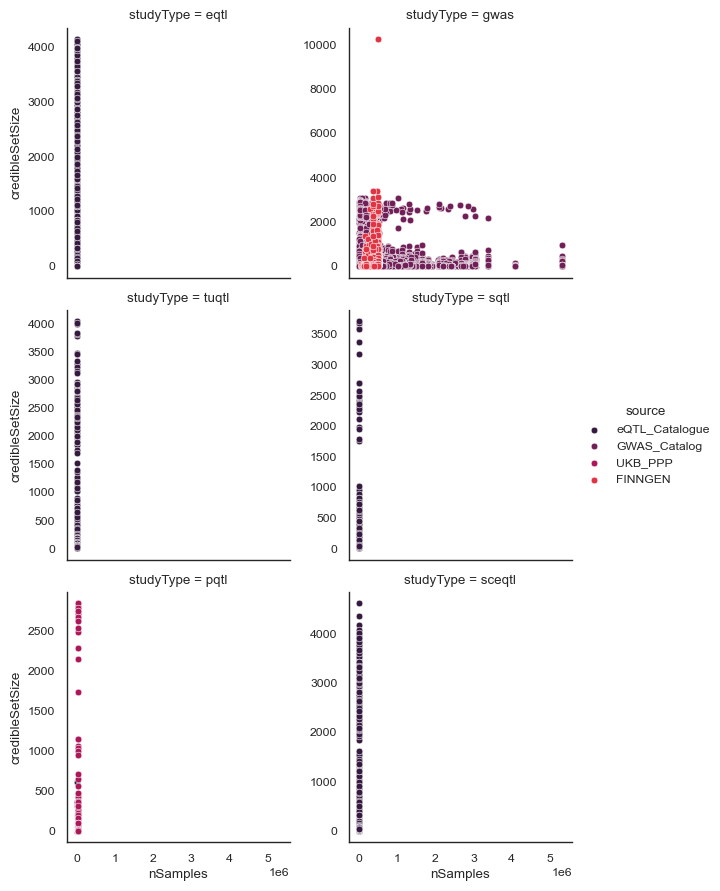

In [10]:
data = df.select(
    "nSamples",
    "credibleSetSize",
    "studyType",
    "studyId",
    pl.when(pl.col("studyId").str.starts_with("GCST"))
    .then(pl.lit("GWAS_Catalog"))
    .when(pl.col("studyId").str.starts_with("FINNGEN"))
    .then(pl.lit("FINNGEN"))
    .when(pl.col("studyId").str.starts_with("UKB"))
    .then(pl.lit("UKB_PPP"))
    .otherwise(pl.lit("eQTL_Catalogue"))
    .alias("source"),
)
g = sns.FacetGrid(data, col="studyType", row="source", hue="source")
g.map(sns.scatterplot, "nSamples", "credibleSetSize")
g.add_legend()

g2 = sns.FacetGrid(data, col="studyType", hue="source", col_wrap=2, sharey=False)
g2.map(
    sns.scatterplot,
    "nSamples",
    "credibleSetSize",
)
g2.add_legend()

plt.show()


### Distributions

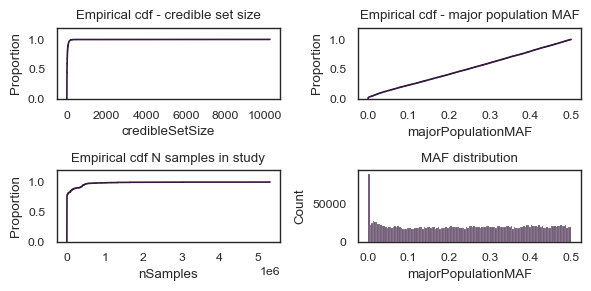

In [11]:
data = df
fig2 = plt.figure(figsize=(6, 3))
ax1 = plt.subplot(2, 2, 1)
ax2 = plt.subplot(2, 2, 2)
ax3 = plt.subplot(2, 2, 3)
ax4 = plt.subplot(2, 2, 4)
sns.ecdfplot(data=data.select("credibleSetSize"), x="credibleSetSize", ax=ax1)
ax1.set_title("Empirical cdf - credible set size")
ax1.set_ylim(ymax=1.2)
ax1.set_yticks([0.0, 0.5, 1.0])
# ax1.axhline(y=1.0, color="red", linestyle="--")

sns.ecdfplot(data=data.select("majorPopulationMAF"), x="majorPopulationMAF", ax=ax2)
ax2.set_title("Empirical cdf - major population MAF")
ax2.set_ylim(ymax=1.2)
ax2.set_yticks([0.0, 0.5, 1.0])
sns.ecdfplot(data=data.select("nSamples"), x="nSamples", ax=ax3)
ax3.set_title("Empirical cdf N samples in study")
ax3.set_ylim(ymax=1.2)
ax3.set_yticks([0.0, 0.5, 1.0])
sns.histplot(data=data.select("majorPopulationMAF"), x="majorPopulationMAF", ax=ax4)
ax4.set_title("MAF distribution")
fig2.tight_layout()

plt.show()


### variance explained vs credible set size

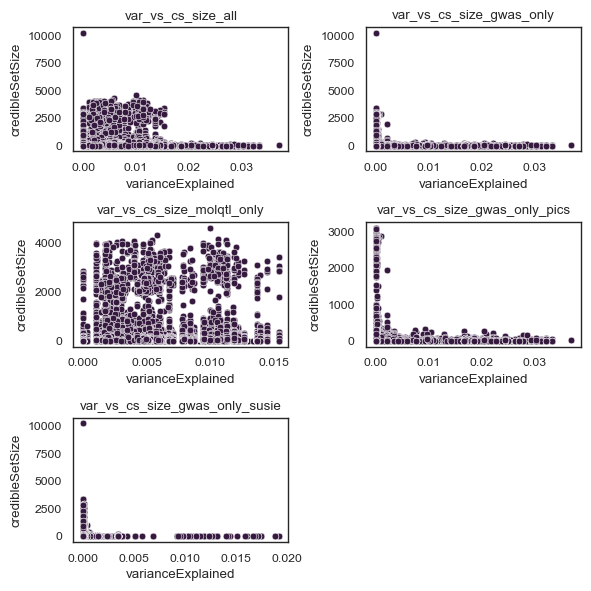

In [12]:
data = df
data2 = df.filter(pl.col("studyType") == "gwas")
data3 = df.filter(pl.col("studyType") != "gwas")
data4 = df.filter(pl.col("studyType") == "gwas").filter(pl.col("finemappingMethod") == "PICS")
data5 = df.filter(pl.col("studyType") == "gwas").filter(pl.col("finemappingMethod") != "PICS")

fig = plt.figure(figsize=(6, 6))
ax1 = plt.subplot(3, 2, 1)
ax2 = plt.subplot(3, 2, 2)
ax3 = plt.subplot(3, 2, 3)
ax4 = plt.subplot(3, 2, 4)
ax5 = plt.subplot(3, 2, 5)
plot_var_vs_cs_size(data, ax1).set_title("var_vs_cs_size_all")
plot_var_vs_cs_size(data2, ax2).set_title("var_vs_cs_size_gwas_only")
plot_var_vs_cs_size(data3, ax3).set_title("var_vs_cs_size_molqtl_only")
plot_var_vs_cs_size(data4, ax4).set_title("var_vs_cs_size_gwas_only_pics")
plot_var_vs_cs_size(data5, ax5).set_title("var_vs_cs_size_gwas_only_susie")
fig.tight_layout()

plt.show()


### variance explained vs MAF

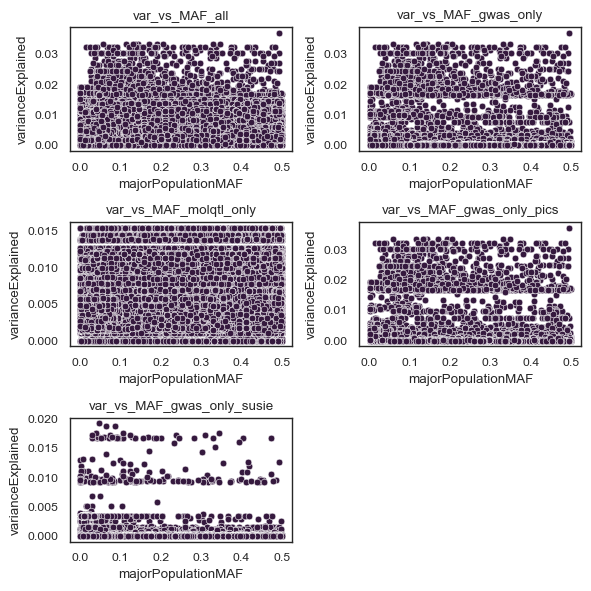

In [ ]:
data = df
data2 = df.filter(pl.col("studyType") == "gwas")
data3 = df.filter(pl.col("studyType") != "gwas")
data4 = df.filter(pl.col("studyType") == "gwas").filter(pl.col("finemappingMethod") == "PICS")
data5 = df.filter(pl.col("studyType") == "gwas").filter(pl.col("finemappingMethod") != "PICS")

fig = plt.figure(figsize=(6, 6))
ax1 = plt.subplot(3, 2, 1)
ax2 = plt.subplot(3, 2, 2)
ax3 = plt.subplot(3, 2, 3)
ax4 = plt.subplot(3, 2, 4)
ax5 = plt.subplot(3, 2, 5)
plot_var_vs_MAF(data, ax1).set_title("var_vs_MAF_all")
plot_var_vs_MAF(data2, ax2).set_title("var_vs_MAF_gwas_only")
plot_var_vs_MAF(data3, ax3).set_title("var_vs_MAF_molqtl_only")
plot_var_vs_MAF(data4, ax4).set_title("var_vs_MAF_gwas_only_pics")
plot_var_vs_MAF(data5, ax5).set_title("var_vs_MAF_gwas_only_susie")
fig.tight_layout()

plt.show()


### variant effect counts

.when([(col("count")) <= (dyn int: 10)]).then("1-10").otherwise(.when([(col("count")) <= (dyn int: 100)]).then("11-100").otherwise(.when([(col("count")) <= (dyn int: 1000)]).then("101-1000").otherwise(.when([(col("count")) <= (dyn int: 10000)]).then("1001-10000").otherwise(.when([(col("count")) <= (dyn int: 10000)]).then("10001-10000").otherwise(null)))))
we have 25 unique variants in credible sets


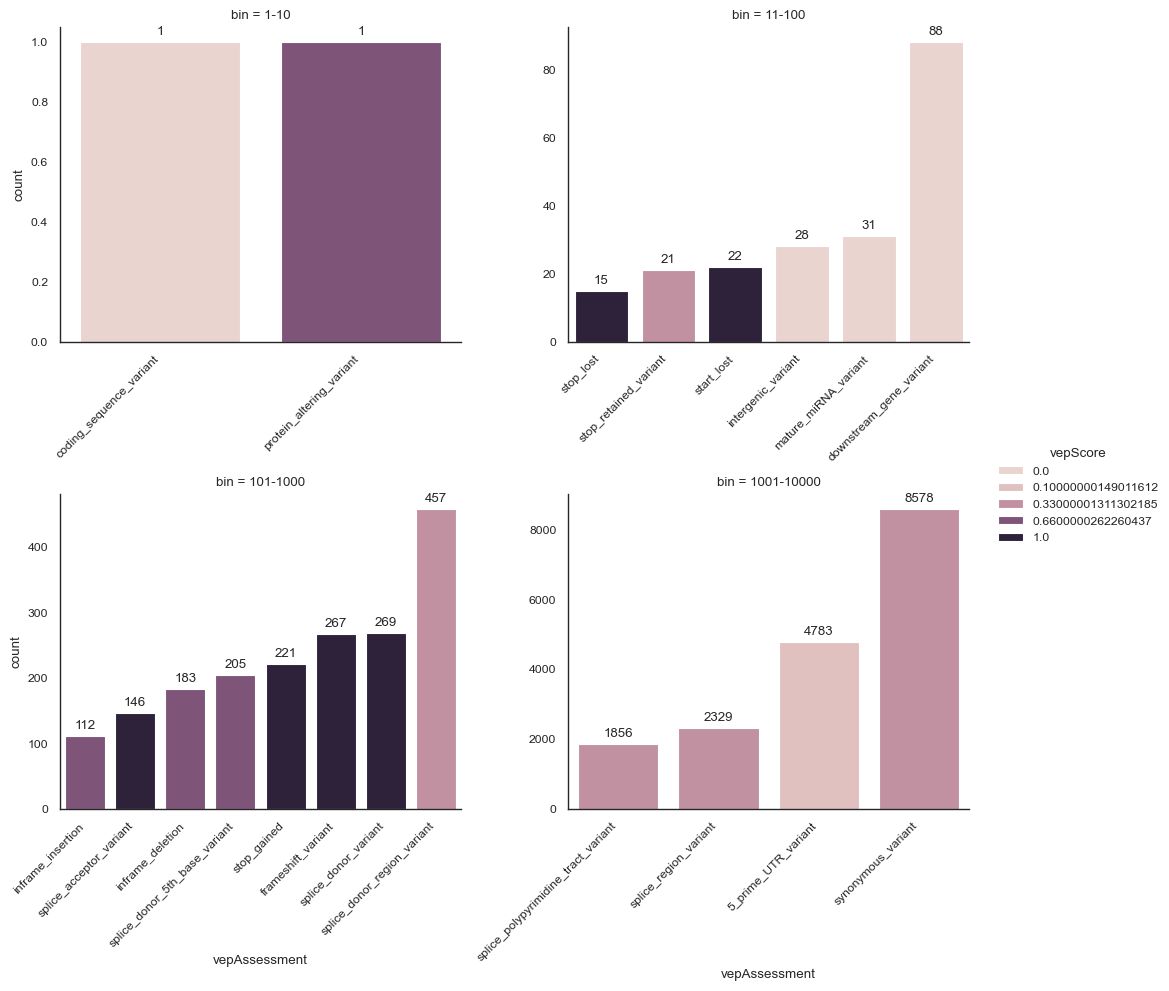

In [68]:
threshold = 1000

bins = [(0, 10), (10, 100), (100, 1000), (1000, 10000), (10000, 10000)]
bin_names = [f"{b[0] + 1}-{b[1]}" for b in bins]
last_bin_name = f"{bins[-1][1] + 1}-"
start = pl.when(pl.col("count") <= bins[0][1]).then(pl.lit(bin_names[0]))
step = start
for idx, bin in enumerate(bins[1:]):
    step = step.when(pl.col("count") <= bin[1]).then(pl.lit(bin_names[idx + 1]))

step.otherwise(pl.lit(last_bin_name))
print(step)

n_variants = df.select("variantId").unique().shape[0]

data = (
    df.select(
        pl.col("vepEffect").struct.field("assessment").alias("vepAssessment"),
        pl.col("vepEffect").struct.field("normalisedScore").alias("vepScore"),
        pl.col("variantId"),
    )
    .unique(subset=["variantId"])
    .group_by("vepAssessment")
    .agg(
        pl.len().alias("count"),
        pl.max("vepScore").alias("vepScore"),
    )
    .sort(by="count")
    .with_columns(bin=step)
)
print(f"we have {data.shape[0]} unique variants in credible sets")
g = sns.catplot(
    data=data,
    x="vepAssessment",
    y="count",
    kind="bar",
    col="bin",
    sharey=False,
    hue="vepScore",
    sharex=False,
    col_wrap=2,
)
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)  #
        label.set_horizontalalignment("right")  # or 'left', 'center' depending on rotation direction
    for container in ax.containers:
        ax.bar_label(container, padding=3)
g.tight_layout()
plt.show()


We have ~900k unique lead variants 